# E1 213
Mehul Darak

Umang Majumder

Soumyadeep Sarma

In [35]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# text Processing

In [ ]:
def process_text(file, train = 0.5, test = 0.5):
    input = pd.read_json(file, lines=True)
    cats = input.category.unique()
    catlist = []
    for i in cats:
        count = len(input[input.category==i])
        catlist.append((i,count))
    
    sorted_catlist = sorted(catlist, key = lambda tup: tup[1], reverse = True)
    classes = sorted_catlist[:12]
    classes = np.array(classes)
    class_counts = classes[:,1]
    class_names = list(classes[:,0])
    input = input.sample(frac=1).reset_index(drop=True)
    data = input[[i in class_names for i in input.category]]
    data = data[:2000] # 400 headlines considered
    data= data.drop(['link','authors','date','short_description'],axis=1)
    data = data.reset_index(drop=True)
    headlines = list(data.headline)
    tiv = TfidfVectorizer(analyzer='word',stop_words='english')
    ti_wm = tiv.fit_transform(headlines)
    ti_tokens = tiv.get_feature_names_out()
    y  = [class_names.index(i) for i in data.category]
    y = np.array(y)
    n = len(y)
    test_n = int(n*test)
    train_n = int(n*train)
    
    y_test = y[:test_n]
    y_train = y[test_n:train_n+test_n]
    
    x_test = ti_wm[:test_n]
    x_train = ti_wm[test_n:train_n+test_n]
    return (x_test,y_test,x_train,y_train)

# K-Means Clustering

# E Step
### Calculate P(Z | X)
in K Means, probability that a specific point belongs to a specific gaussian/cluster is either 1 or 0, so we just assign it to the nearest cluster mean
# M Step
### Update Theta
Here Theta represents the mean and variance of the gaussians. As the variances are equal, we are only updating the means of the clusters

# Objective Function
We minimise the sum of the distances of points from the cluster means

$\sum_{c \in classes} \sum_{i \in c \space points} (x_c^{(i)} - \bar x_c)$

In [143]:
class KMeans:
    def __init__(self,X,classes,dist):
        self.classes = classes
        self.X = np.array(X) # Each Row is a datapoint
        self.n = len(X)
        self.dist = dist
    def E(self,means): # Cluster points to means
        y = -(np.ones(self.n))
        for i in range(self.n):
            point = self.X[i]
            closest_mean_ind = 0
            for j in range(self.classes):
                if self.dist(point,means[j]) < self.dist(point,means[closest_mean_ind]):
                    closest_mean_ind = j
            y[i] = closest_mean_ind
        return y
            
    def M(self,y): # Update Means
        new_means = []
        for c in range(self.classes):
            c_ind = [i==c for i in y]
            Xc = self.X[c_ind]
            mean_c = np.mean(Xc,axis=0)
            new_means.append(mean_c)
        return new_means
    def objective(self,y,means):
        obj = 0
        for c in range(self.classes):
            yc = [i==c for i in y]
            xc = self.X[yc]
            meanc = means[c]
            dist_arr = [self.dist(meanc, i) for i in xc]
            obj += np.sum(dist_arr)
        return obj
    def converge(self,steps = 10):
        means = []
        obj = []
        for j in range(self.classes):
            means.append(self.X[j])
        for i in range(steps):
            y = self.E(means)
            obj.append(self.objective(y,means))
            means = self.M(y)
        return y,means,obj

In [67]:
x = [[1,2,3], [3,4,5]]

np.mean(x,axis=0)

array([2., 3., 4.])

In [49]:
input = pd.read_csv("faithful.csv")

In [51]:
data = np.array(input[["eruptions","waiting"]])

In [128]:
np.random.shuffle(data)

In [129]:
def euclidean(x,y):
    return np.linalg.norm(x-y)

In [145]:
km = KMeans(data,2,euclidean)

In [146]:
y,means,obj = km.converge(20)

### Minimising the objective function

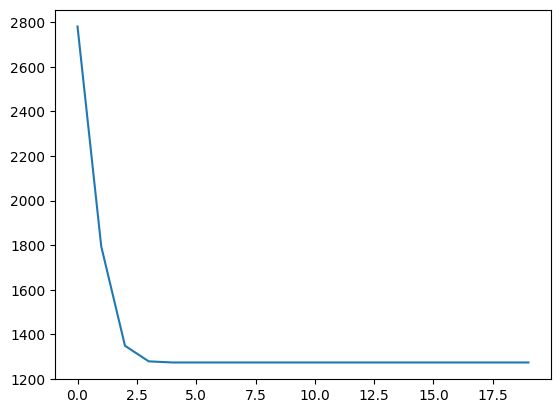

In [147]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(obj)

In [133]:
y_0 = [i==0 for i in y]
y_1 = [i==1 for i in y]

In [134]:
x_1 = data[y_1]
x_0 = data[y_0]

In [136]:
means = np.array(means)

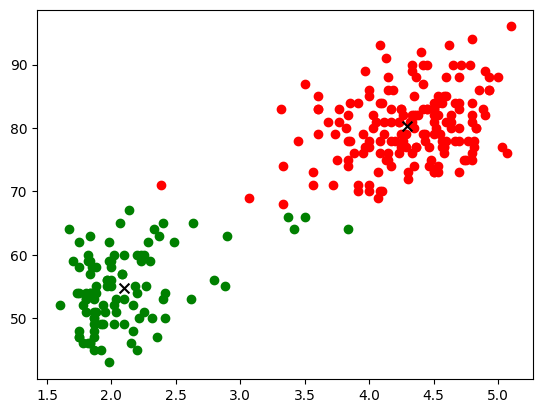

In [137]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x_0[:,0], x_0[:,1], c="green")
ax.scatter(x_1[:,0], x_1[:,1], c="red")
ax.scatter(means[:,0], means[:,1], marker = 'x',c="black", s = 50)

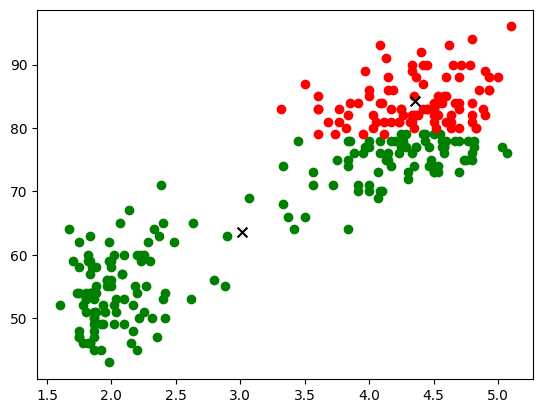

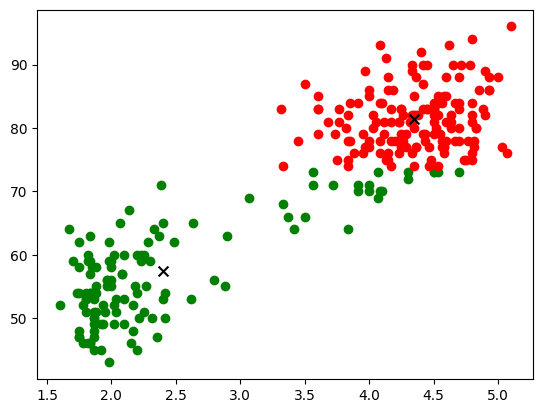

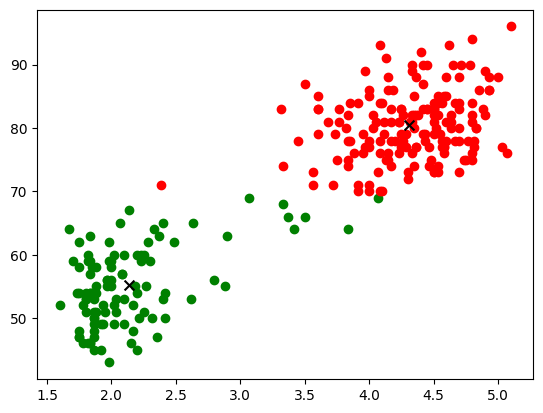

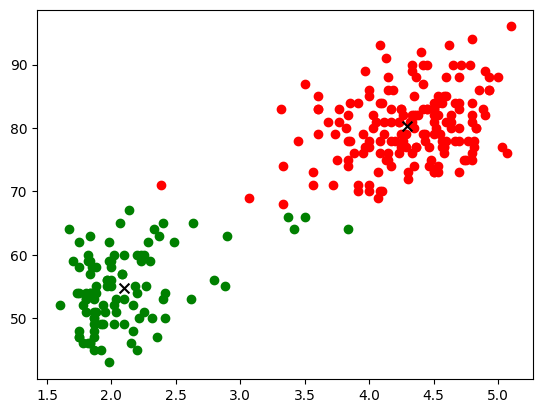

In [139]:

for i in range(1,5):
    km = KMeans(data,2,euclidean)
    y,means = km.converge(i)
    y_0 = [i==0 for i in y]
    y_1 = [i==1 for i in y]
    x_0 = data[y_0]
    x_1 = data[y_1]
    means = np.array(means)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(x_0[:,0], x_0[:,1], c="green")
    ax.scatter(x_1[:,0], x_1[:,1], c="red")
    ax.scatter(means[:,0], means[:,1], marker = 'x',c="black", s = 50)

# PCA

# Standardization:
PCA begins by standardizing the data to have zero mean and unit variance across each feature dimension. This step ensures that all features contribute equally to the PCA analysis.

## Covariance Matrix:
After standardization, PCA computes the covariance matrix of the standardized data. The covariance matrix summarizes the relationships between all pairs of variables in the dataset.

## Eigenvalue Decomposition:
Next, PCA performs eigenvalue decomposition or singular value decomposition (SVD) on the covariance matrix to find its eigenvectors and eigenvalues.
        The eigenvectors represent the directions or axes of maximum variance in the data, while the eigenvalues represent the magnitude of variance along these directions.

## Selection of Principal Components:
PCA ranks the eigenvectors (principal components) based on their corresponding eigenvalues in descending order.
        The principal components with the highest eigenvalues capture the most variance in the data and are retained, while the rest are discarded.

## Dimensionality Reduction:
Finally, PCA projects the original data onto the subspace spanned by the selected principal components.

In [2]:
class PCA:
    def __init__(self, pca_comp = 2): #The hyperparameter of projected dimensionality is assigned a default value of 2 here
        self.pca_comp = pca_comp
    def fit(self, X):
        #Standardizing data to reduce multicolinearity
        self.mean = np.mean(X,axis=0)
        #self.std = np.std(X,axis=0)
        X = X-self.mean   #For each feature, the data is standardized over data points
        
        #Covariance of X but (data points,features) -> (features,data points)
        covar = np.cov(X.T)
        
        eigval,eigvec = np.linalg.eigh(covar)
        
        ind = np.argsort(eigval)[::-1]
        
        eigval = eigval[ind]
        eigvec = eigvec[:,ind]
        
        self.pca_comp = eigvec[:,0:self.pca_comp]
        
    def transform(self,X):
        X = X-self.mean
        return np.dot(X,self.pca_comp)
        

In [9]:
np.random.normal((0,0,2))

array([-0.0977949 ,  0.80796515,  2.3275709 ])

In [69]:
points = []
color = []
for i in range(10):
    points.append(np.random.normal((-5,-5,0), 0.1))
    points.append(np.random.normal((6,2,4), 0.1))
    points.append(np.random.normal((3,7,1), 0.1))
    color = color + [[1,0,0], [0,1,0], [0,0,1]]

points = np.array(points)

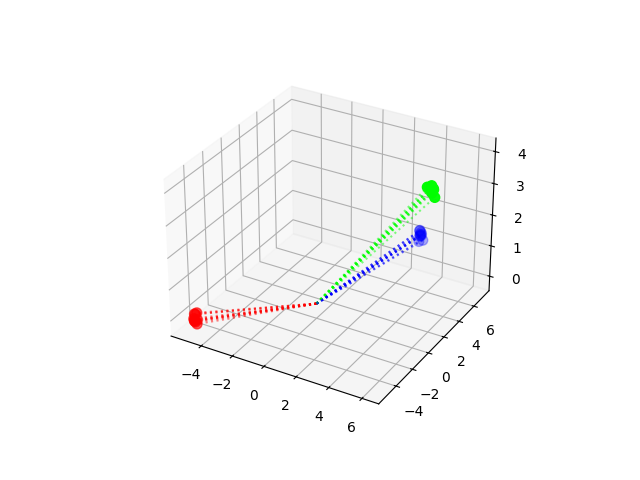

In [87]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c = color, s = 50)
n = len(points)
for i in range(n):
    ax.plot([0, points[i,0]], [0, points[i,1]], [0, points[i,2]], c = color[i], ls = ":", alpha = 0.5)

In [51]:
pca = PCA(pca_comp = 2)

In [52]:
pca.fit(points)
new_points = pca.transform(points)

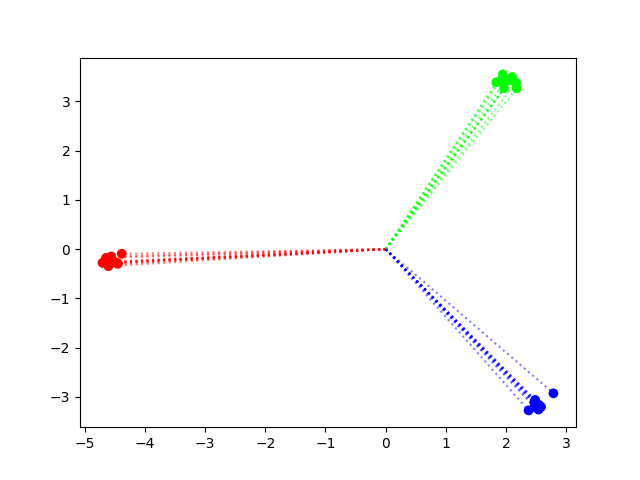

In [84]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(new_points[:,0], new_points[:,1], c = color)

for i in range(n):
    ax.plot([0, new_points[i,0]], [0, new_points[i,1]], c = color[i], ls = ":", alpha = 0.5)

In [88]:
pca = PCA(pca_comp = 1)
pca.fit(points)
newnew_points = pca.transform(points)

C:\Users\umang\AppData\Local\Temp\ipykernel_31364\3281692717.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


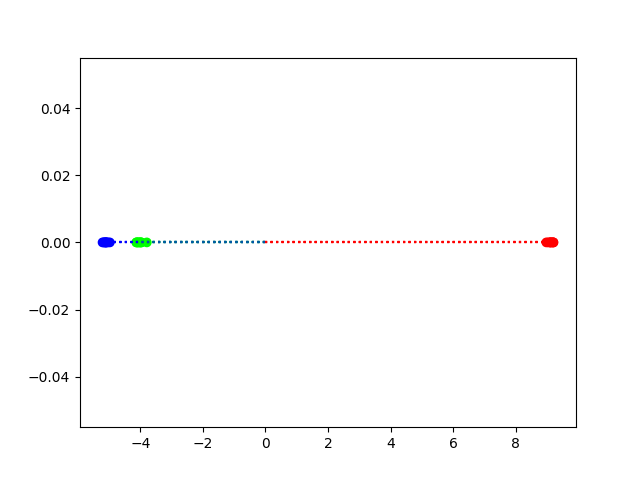

In [94]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(newnew_points[:,0], [0]*n, c = color)

for i in range(n):
    ax.plot([0, newnew_points[i]], [0,0] , c = color[i], ls = ":", alpha = 0.5)

# K Means on images

In [18]:
def euclidean(x,y):
    return np.linalg.norm(x-y)

### Image Processing

In [4]:
classes = os.listdir("raw-img")
img_matrix = [] #img_matrix (10 x (number of images in class) x (100,100) )
for c in classes:
    class_file = f"raw-img/{c}"
    img_files = os.listdir(class_file)
    print(c)
    print(len(img_files))
    temp = []
    for i in img_files:
        #print(i)
        #print(class_file)
        #print(i)
        img = cv2.imread(class_file + "/" + i)
        new_dim = (64,64)
        new_img = cv2.resize(img, new_dim, interpolation = cv2.INTER_AREA)
        new_img.shape = (12288,)
        temp.append(new_img)
    temp = np.array(temp)
    print("starting PCA")
    pca = PCA(pca_comp = 4096)
    pca.fit(temp)
    new_temp = pca.transform(temp)
    print(new_temp.shape)
    img_matrix.append(new_temp) #img_matrix (10 x (number of images in class) x 4096 )

pecora
1820
starting PCA
(1820, 4096)
elefante
1446


libpng warning: iCCP: known incorrect sRGB profile


starting PCA
(1446, 4096)
farfalla
2112


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

starting PCA
(2112, 4096)
gatto
1668
starting PCA
(1668, 4096)
cane
4863
starting PCA
(4863, 4096)
cavallo
2623
starting PCA
(2623, 4096)
mucca
1866
starting PCA
(1866, 4096)
ragno
4821
starting PCA
(4821, 4096)
scoiattolo
1862
starting PCA
(1862, 4096)
gallina
3098
starting PCA
(3098, 4096)


In [19]:
# Hyperparameters grid
learning_rates = [0.001, 0.01, 0.1]
num_hidden_layers_list = [3, 4]
neurons_per_layer_list = [5, 10, 15]
n_classifiers_list = [5, 10]
epochs_list = [50, 100, 200]

best_accuracy = 0
best_params = {}

for lr, num_hidden_layers, neurons_per_layer, n_classifiers, epochs in product(learning_rates, num_hidden_layers_list, neurons_per_layer_list, n_classifiers_list, epochs_list):
    adaboost = AdaBoostClassifier(n_classifiers, input_size, output_size, num_hidden_layers, neurons_per_layer, learning_rate=lr, epochs=epochs)
    adaboost.fit(X_train, Y_train)
    predictions = adaboost.predict(X_val)
    accuracy = np.mean(predictions == np.argmax(Y_val, axis=1))
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': lr, 'num_hidden_layers': num_hidden_layers, 'neurons_per_layer': neurons_per_layer, 'n_classifiers': n_classifiers, 'epochs': epochs}

print("Best Validation Accuracy:", best_accuracy)
print("Best Hyperparameters:", best_params)

C:\Users\DELL\AppData\Local\Temp\ipykernel_11716\4012335362.py:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Best Validation Accuracy: 0.15
Best Hyperparameters: {'learning_rate': 0.01, 'num_hidden_layers': 3, 'neurons_per_layer': 5, 'n_classifiers': 10, 'epochs': 100}


In [15]:
for i in range(10):
    print(img_matrix[i].shape)

(1820, 4096)
(1446, 4096)
(2112, 4096)
(1668, 4096)
(4863, 4096)
(2623, 4096)
(1866, 4096)
(4821, 4096)
(1862, 4096)
(3098, 4096)


In [8]:
y = []
X = []

for i in range(10):
    for j in range(len(img_matrix[i])):
        X.append(img_matrix[i][j])
        y.append(i)

In [13]:
y = np.array(y)
X = np.array(X)

In [14]:
X.shape

(26179, 4096)

In [33]:
km = KMeans(X,10,euclidean)

In [34]:
y_pred, means, obj = km.converge(100)

Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99


In [25]:
y_pred

array([7., 1., 6., ..., 1., 1., 1.])

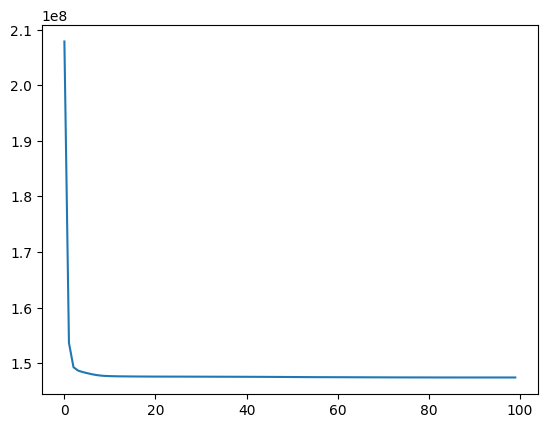

In [36]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(obj)

In [26]:
def confusion_matrix(y_pred, y):
    y_pred_series = pd.Series(y_pred, name = "Pred")
    y_series = pd.Series(y,name = "Actual")
    cm = pd.crosstab(y_pred_series, y_series)
    return cm

In [29]:
cm = confusion_matrix(y_pred,y)

In [30]:
cm

Actual,0,1,2,3,4,5,6,7,8,9
Pred,,,,,,,,,,
0.0,33,40,144,151,405,45,46,570,74,28
1.0,217,203,103,131,543,364,287,191,145,317
2.0,122,119,160,213,619,233,154,724,184,150
3.0,319,189,380,166,525,356,226,640,310,556
4.0,8,32,300,103,91,84,10,372,20,147
5.0,263,196,145,200,742,264,253,590,287,258
6.0,225,201,65,175,560,397,268,377,196,336
7.0,122,136,413,191,347,284,133,499,126,320
8.0,344,179,147,185,671,262,288,474,306,584


In [31]:
def F1(cm):
    TP = np.diag(cm)
    FP = cm.sum(axis = 1) - TP
    FN = cm.sum(axis = 0) - TP
    print(f"TP:{TP}")
    print()
    print(f"FP:{FP}")
    print()
    print(f"FN:{FN}")
    print()
    precision = TP/(TP+FP)
    print(f"precision: {precision}")
    print()
    recall = TP/(TP+FN)
    
    print(f"recall: {recall}")
    F1 = (2*precision*recall)/(precision+recall)
    return F1

In [32]:
f1 = F1(cm)

TP:[ 33 203 160 166  91 264 268 499 306 402]

FP:Pred
0.0    1503
1.0    2298
2.0    2518
3.0    3501
4.0    1076
5.0    2934
6.0    2532
7.0    2072
8.0    3134
9.0    2219
dtype: int64

FN:Actual
0    1787
1    1243
2    1952
3    1502
4    4772
5    2359
6    1598
7    4322
8    1556
9    2696
dtype: int64

precision: Pred
0.0    0.021484
1.0    0.081168
2.0    0.059746
3.0    0.045269
4.0    0.077978
5.0    0.082552
6.0    0.095714
7.0    0.194088
8.0    0.088953
9.0    0.153377
dtype: float64

recall: Actual
0    0.018132
1    0.140387
2    0.075758
3    0.099520
4    0.018713
5    0.100648
6    0.143623
7    0.103505
8    0.164339
9    0.129761
dtype: float64


In [42]:
def entropy(labels):
    """Calculate the entropy of a list of labels."""
    _, counts = np.unique(labels, return_counts=True)
    probs = counts / len(labels)
    return -np.sum(probs * np.log2(probs + 1e-10))

def mutual_information(labels_true, labels_pred):
    """Calculate the mutual information between two lists of labels."""
    # Calculate joint entropy
    joint_labels = np.vstack([labels_true, labels_pred])
    H_joint = entropy(joint_labels.T)

    # Calculate individual entropies
    H_true = entropy(labels_true)
    H_pred = entropy(labels_pred)

    # Calculate mutual information
    MI = H_true + H_pred - H_joint
    return MI

def normalized_mutual_information(labels_true, labels_pred):
    """Calculate the normalized mutual information between two lists of labels."""
    MI = mutual_information(labels_true, labels_pred)

    # Normalize mutual information
    H_true = entropy(labels_true)
    H_pred = entropy(labels_pred)
    NMI = 2 * MI / (H_true + H_pred + 1e-10)  # Add small epsilon to avoid division by zero
    return NMI

In [43]:
nmi_score = normalized_mutual_information(y, y_pred)
print("Normalized Mutual Information (NMI):", nmi_score)

Normalized Mutual Information (NMI): 0.5777087170592343


# Report for Transformer Model

## Model Architecture
The Transformer model consists of multiple layers of self-attention and feed-forward neural networks. Each layer in the Transformer comprises two sub-layers: a multi-head self-attention mechanism and a position-wise feed-forward network. Additionally, residual connections and layer normalization are applied to each sub-layer to facilitate training.

## Mathematical Details
### Self-Attention Mechanism
The self-attention mechanism computes attention scores for each token in the input sequence based on its relation to all other tokens. The attention scores are used to compute a weighted sum of the values associated with each token, resulting in a context vector for each token. The self-attention mechanism is defined by the following equations:
$
1. \text{Query, Key, and Value computation: } Q = XW_Q, K = XW_K, V = XW_V
2. \text{Attention scores: } \text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$
where $X$ is the input sequence, $W_Q$, $W_K$, and $W_V$ are learnable parameter matrices, and $d_k$ is the dimensionality of the key vectors.

### Feed-Forward Network
The feed-forward network applies a two-layer fully connected neural network to each token's context vector independently. The feed-forward network is defined by the following equations:
$
1. \text{First linear transformation: } \text{FFN}_1 = \text{ReLU}(XW_1 + b_1)
2. \text{Second linear transformation: } \text{FFN}_2 = \text{FFN}_1W_2 + b_2
$

### Positional Encoding
To incorporate positional information into the model, positional encoding vectors are added to the input embeddings. The positional encoding vectors are computed based on sine and cosine functions of different frequencies.

### Transformer Encoder
The Transformer encoder consists of multiple layers of self-attention and feed-forward networks. Each layer in the encoder independently processes the input sequence and passes its output to the next layer. The final output of the encoder is used for classification.

### Loss Function
The loss function used for training the Transformer model is the cross-entropy loss, which measures the difference between the predicted class probabilities and the true labels.

## Training Procedure
The Transformer model is trained using stochastic gradient descent (SGD) with backpropagation. The training loop iterates over the dataset for a fixed number of epochs, updating the model parameters after each iteration. Learning rate scheduling and early stopping techniques may be employed to improve convergence and prevent overfitting.

## Results
The performance of the Transformer model is evaluated on both training and validation datasets using metrics such as accuracy, precision, recall, and F1-score. Additionally, visualization techniques such as confusion matrices and learning curves may be utilized to analyze the model's behavior and identify potential areas for improvement.



In [2]:
x_test,y_test,x_train,y_train = process_text('News_Category_Dataset_v3.json', train = 0.5, test = 0.5) 
pca = PCA(pca_comp = 100)
pca.fit(x_train)
X_train = pca.transform(x_train)
pca = PCA(pca_comp = 100)
pca.fit(x_test)
X_test = pca.transform(x_test)

# Transformer on text

In [49]:
class SelfAttention:
    def __init__(self, size):
        self.size = size
        self.Wq = np.random.randn(size, size) * 0.1
        self.Wk = np.random.randn(size, size) * 0.1
        self.Wv = np.random.randn(size, size) * 0.1

    def forward(self, x):
        self.x = x
        self.Q = np.dot(x, self.Wq)
        self.K = np.dot(x, self.Wk)
        self.V = np.dot(x, self.Wv)

        self.scores = np.dot(self.Q, self.K.T) / np.sqrt(self.size)
        self.weights = softmax(self.scores)
        self.z = np.dot(self.weights, self.V)
        return self.z

    def backward(self, dout):
        # dout shape is (batch_size, size)
        dV = np.dot(self.weights.T, dout)
        dWeights = np.dot(dout, self.V.T)

        # Calculate scores gradient
        dScores = dWeights * self.weights * (1 - self.weights)
        
        # Correcting the gradient calculation
        dQ = np.dot(dScores, self.K) / np.sqrt(self.size)
        dK = np.dot(dScores.T, self.Q) / np.sqrt(self.size)

        dx = np.dot(dQ, self.Wq.T) + np.dot(dK, self.Wk.T) + np.dot(dV, self.Wv.T)
        
        self.dWq = np.dot(self.x.T, dQ)
        self.dWk = np.dot(self.x.T, dK)
        self.dWv = np.dot(self.x.T, dV)

        # Normally learning rate and update step happen outside
        return dx

# Ensure softmax handles batch dimensions correctly
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

In [50]:
class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.1
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.1
        self.b2 = np.zeros(output_dim)

    def forward(self, x):
        self.x = x
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = np.maximum(0, self.z1)  # ReLU activation
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        return self.z2

    def backward(self, dout):
        dZ2 = dout
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * (self.z1 > 0)  # Derivative of ReLU

        dx = np.dot(dZ1, self.W1.T)

        self.dW2 = np.dot(self.a1.T, dZ2)
        self.db2 = np.sum(dZ2, axis=0)
        self.dW1 = np.dot(self.x.T, dZ1)
        self.db1 = np.sum(dZ1, axis=0)

        return dx


In [51]:
class TransformerEncoder:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.attention = SelfAttention(input_dim)
        self.mlp = MLP(input_dim, hidden_dim, output_dim)

    def forward(self, x):
        # Pass x through the attention mechanism, then MLP
        x = self.attention.forward(x)
        x = self.mlp.forward(x)
        return x

    def backward(self, dout):
        # Pass gradients back through MLP then attention mechanism
        dout = self.mlp.backward(dout)
        dout = self.attention.backward(dout)
        return dout

In [52]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.wait = 0
        self.stopped_epoch = 0
        self.stop_training = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop_training = True
                self.stopped_epoch = epoch
                print(f"Training stopped: no improvement in {self.patience} epochs")

    def on_train_end(self):
        if self.stop_training:
            print(f"Early stopping triggered. Stopped at epoch {self.stopped_epoch}")


In [53]:
def update_parameters(layers, learning_rate=0.001):
    for layer in layers:
        if hasattr(layer, 'Wq'):
            layer.Wq -= learning_rate * layer.dWq
            layer.Wk -= learning_rate * layer.dWk
            layer.Wv -= learning_rate * layer.dWv
        if hasattr(layer, 'W1'):
            layer.W1 -= learning_rate * layer.dW1
            layer.b1 -= learning_rate * layer.db1
            layer.W2 -= learning_rate * layer.dW2
            layer.b2 -= learning_rate * layer.db2

def print_diagnostics(layer):
    if hasattr(layer, 'dWq'):
        print(f"dWq Norm: {np.linalg.norm(layer.dWq)}")
    if hasattr(layer, 'dW1'):
        print(f"dW1 Norm: {np.linalg.norm(layer.dW1)}")

In [54]:
def mean_squared_error(predictions, targets):
    return ((predictions - targets) ** 2).mean()

def mse_derivative(predictions, targets):
    return 2 * (predictions - targets) / predictions.shape[0]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [55]:
class SimpleClassifier:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.biases = np.zeros(output_dim)

    def forward(self, X):
        # Convert X to ndarray if it's a matrix
        X = np.asarray(X)

        logits = np.dot(X, self.weights) + self.biases
        exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def backward(self, X, y):
        # Convert X to ndarray if it's a matrix
        X = np.asarray(X)

        probabilities = self.forward(X)
        probabilities[range(len(y)), y] -= 1
        dW = np.dot(X.T, probabilities) / len(y)
        dB = np.sum(probabilities, axis=0) / len(y)
        return dW, dB

    def update_params(self, dW, dB, learning_rate):
        self.weights -= learning_rate * dW
        self.biases -= learning_rate * dB

    def compute_loss_and_accuracy(self, X, y):
        # Convert X to ndarray if it's a matrix
        X = np.asarray(X)

        probabilities = self.forward(X)
        predictions = np.argmax(probabilities, axis=1)
        accuracy = np.mean(predictions == y)
        log_probs = -np.log(probabilities[range(len(y)), y])
        loss = np.mean(log_probs)
        return loss, accuracy


In [56]:
import matplotlib.pyplot as plt
# Print unique labels to see what's there
unique_labels = np.unique(y_train)
print("Unique labels in y_train:", unique_labels)
num_classes = len(np.unique(y_train))  

Unique labels in y_train: [0 1 2 3 4 5 6]


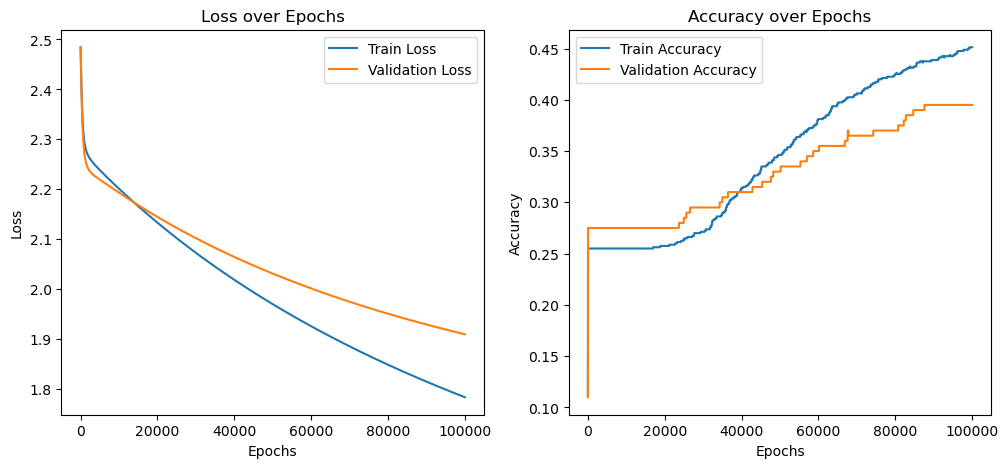

In [12]:
# Ensure this matches your true number of classes
model = SimpleClassifier(input_dim=100, output_dim=num_classes)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 100000
learning_rate = 0.01

for epoch in range(epochs):
    # Backward and update model
    dW, dB = model.backward(X_train, y_train)
    model.update_params(dW, dB, learning_rate)

    # Compute loss and accuracy
    train_loss, train_accuracy = model.compute_loss_and_accuracy(X_train, y_train)
    val_loss, val_accuracy = model.compute_loss_and_accuracy(X_val, y_val)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Append to lists for tracking
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
test_loss, test_accuracy = model.compute_loss_and_accuracy(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.10f}")

Test Loss: 2.4979, Test Accuracy: 0.1690000000


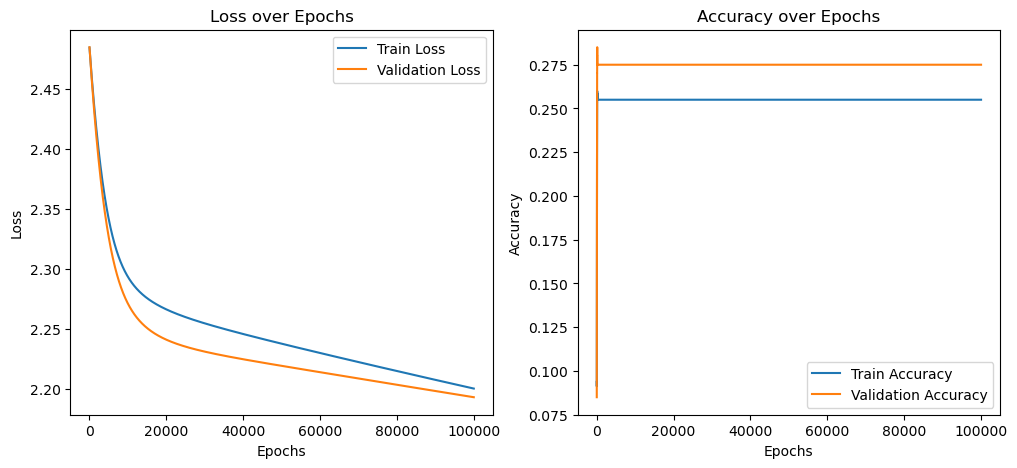

In [18]:
# Ensure this matches your true number of classes
model = SimpleClassifier(input_dim=100, output_dim=num_classes)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 100000
learning_rate = 0.001

for epoch in range(epochs):
    # Backward and update model
    dW, dB = model.backward(X_train, y_train)
    model.update_params(dW, dB, learning_rate)

    # Compute loss and accuracy
    train_loss, train_accuracy = model.compute_loss_and_accuracy(X_train, y_train)
    val_loss, val_accuracy = model.compute_loss_and_accuracy(X_val, y_val)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Append to lists for tracking
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
test_loss, test_accuracy = model.compute_loss_and_accuracy(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.10f}")

Test Loss: 2.2732, Test Accuracy: 0.2740000000


# Insufficient Compute for Early stopping
Early stoppping required us to have a much higher than existing compute, we would request you to check our code on your system and give us a feedback on whether is a good criterion. Next few blocks have early stopping. So now we would do L2 regularisation to avoid overfitting.

In [ ]:
# Early stopping to prevent a clear overfitting as we see
# Assume X_train, y_train, X_val, y_val are predefined
num_classes = len(np.unique(y_train))  
model = SimpleClassifier(input_dim=100, output_dim=num_classes)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 300000
learning_rate = 0.001
patience = 10
best_val_loss = np.inf
epochs_no_improve = 0

for epoch in range(epochs):
    # Backward and update model
    dW, dB = model.backward(X_train, y_train)
    model.update_params(dW, dB, learning_rate)

    # Compute loss and accuracy
    train_loss, train_accuracy = model.compute_loss_and_accuracy(X_train, y_train)
    val_loss, val_accuracy = model.compute_loss_and_accuracy(X_val, y_val)

    # Append to lists for tracking
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve == patience:
        print(f"Stopping early at epoch {epoch+1}")
        break

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
test_loss, test_accuracy = model.compute_loss_and_accuracy(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.10f}")

In [ ]:
# Early stopping to prevent a clear overfitting as we see
# Assume X_train, y_train, X_val, y_val are predefined
num_classes = len(np.unique(y_train))  
model = SimpleClassifier(input_dim=100, output_dim=num_classes)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 300000
learning_rate = 0.01
patience = 10
best_val_loss = np.inf
epochs_no_improve = 0

for epoch in range(epochs):
    # Backward and update model
    dW, dB = model.backward(X_train, y_train)
    model.update_params(dW, dB, learning_rate)

    # Compute loss and accuracy
    train_loss, train_accuracy = model.compute_loss_and_accuracy(X_train, y_train)
    val_loss, val_accuracy = model.compute_loss_and_accuracy(X_val, y_val)

    # Append to lists for tracking
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve == patience:
        print(f"Stopping early at epoch {epoch+1}")
        break

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
test_loss, test_accuracy = model.compute_loss_and_accuracy(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.10f}")

# L2 Regularisation for Transformer

In [ ]:
# Changing our function a bit to include reg_lambda
class MLP:
    def __init__(self, input_size, num_hidden_layers, neurons_per_layer, output_size, learning_rate=0.01, epochs=100, reg_lambda=0.01):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.reg_lambda = reg_lambda
        self.weights = []
        self.biases = []
        layer_sizes = [input_size] + [neurons_per_layer] * num_hidden_layers + [output_size]
        self.initialize_weights(layer_sizes)

    def initialize_weights(self, layer_sizes):
        for i in range(len(layer_sizes) - 1):
            weight_matrix = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) / np.sqrt(layer_sizes[i])
            bias_vector = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(weight_matrix)
            self.biases.append(bias_vector)

    def forward_pass(self, X):
        activations = [X]
        for i in range(len(self.weights)):
            net_input = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            activation = np.tanh(net_input)  # Using tanh for hidden layers
            activations.append(activation)
        return activations

    def backward_pass(self, activations, Y, sample_weights):
        output_final = activations[-1]
        delta = output_final - Y
        for i in reversed(range(len(self.weights))):
            weight_gradient = np.dot(activations[i].T, delta) / Y.shape[0] + self.reg_lambda * self.weights[i]
            bias_gradient = np.sum(delta, axis=0, keepdims=True) / Y.shape[0]
            self.weights[i] -= self.learning_rate * weight_gradient
            self.biases[i] -= self.learning_rate * bias_gradient
            if i != 0:
                delta = np.dot(delta, self.weights[i].T) * (1 - np.power(activations[i], 2))  # Derivative of tanh

    def train(self, X, Y):
        for epoch in range(self.epochs):
            activations = self.forward_pass(X)
            self.backward_pass(activations, Y, np.ones((Y.shape[0], 1)))  # Assume equal sample weight


# Transformer on images

In [72]:
y = []
X = []

for i in range(10):
    for j in range(len(img_matrix[i])):
        X.append(img_matrix[i][j])
        y.append(i)

In [73]:
y = np.array(y)
X = np.array(X)

In [78]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [75]:
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
y = y[randomize]

In [76]:
def train_test_validation(X,y,train=0.6,test=0.3):
    n = len(y)
    train_n = int(train*n)
    test_n = int(test*n)
    y_train = y[:train_n]
    X_train = X[:train_n]
    y_test = y[train_n:train_n+test_n]
    X_test = X[train_n:train_n+test_n]
    y_val = y[train_n+test_n:]
    X_val = X[train_n+test_n:]
    return X_train,y_train, X_test, y_test, X_val, y_val

In [77]:
X_train, y_train, X_test, y_test, X_val, y_val = train_test_validation(X,y)

In [79]:

model = SimpleClassifier(input_dim=4096, output_dim=num_classes)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 100000
learning_rate = 0.01

for epoch in range(epochs):
    # Backward and update model
    dW, dB = model.backward(X_train, y_train)
    model.update_params(dW, dB, learning_rate)

    # Compute loss and accuracy
    train_loss, train_accuracy = model.compute_loss_and_accuracy(X_train, y_train)
    val_loss, val_accuracy = model.compute_loss_and_accuracy(X_val, y_val)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Append to lists for tracking
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

IndexError: index 8 is out of bounds for axis 1 with size 7

# Report for Multi-Layer Perceptron (MLP) Classifier

## Introduction
In this report, we present an implementation of a Multi-Layer Perceptron (MLP) classifier for a 12-class classification problem. The MLP is trained using stochastic gradient descent with backpropagation and includes L2 regularization to prevent overfitting.

## Model Architecture
The MLP consists of an input layer, one hidden layer, and an output layer. The hidden layer uses the rectified linear unit (ReLU) activation function, while the output layer utilizes the softmax activation function to generate class probabilities.

## Mathematical Details
### Forward Pass
The forward pass of the MLP involves computing the activations of the hidden layer and output layer using the following equations:
$
1. \text{Hidden layer activation: } \mathbf{a}^{(1)} = \text{ReLU}(\mathbf{X} \cdot \mathbf{W}^{(1)} + \mathbf{b}^{(1)})
2. \text{Output layer activation: } \mathbf{z}^{(2)} = \mathbf{a}^{(1)} \cdot \mathbf{W}^{(2)} + \mathbf{b}^{(2)}
3. \text{Softmax: } \hat{\mathbf{y}} = \text{softmax}(\mathbf{z}^{(2)})
$

### Loss Function
The loss function used is the cross-entropy loss with L2 regularization:
$
\text{Loss} = -\frac{1}{m} \sum_{i=1}^{m} \log(\hat{y}_{i, y_i}) + \frac{\lambda}{2} (\|\mathbf{W}^{(1)}\|_2^2 + \|\mathbf{W}^{(2)}\|_2^2)
$
where $ m $ is the number of samples, $ \hat{y}_{i, y_i} $ is the predicted probability of the correct class for sample $ i $, and $ \lambda $ is the regularization factor.

### Backward Pass
The backward pass involves computing the gradients of the loss with respect to the model parameters using the chain rule:
$
1. \text{Output layer gradients: } \frac{\partial \text{Loss}}{\partial \mathbf{W}^{(2)}}, \frac{\partial \text{Loss}}{\partial \mathbf{b}^{(2)}}
2. \text{Hidden layer gradients: } \frac{\partial \text{Loss}}{\partial \mathbf{W}^{(1)}}, \frac{\partial \text{Loss}}{\partial \mathbf{b}^{(1)}}
$

### Parameter Updates
The model parameters are updated using gradient descent with L2 regularization:
$
\mathbf{W}^{(1)} \leftarrow \mathbf{W}^{(1)} - \alpha \left( \frac{\partial \text{Loss}}{\partial \mathbf{W}^{(1)}} + \lambda \mathbf{W}^{(1)} \right)
$
$
\mathbf{W}^{(2)} \leftarrow \mathbf{W}^{(2)} - \alpha \left( \frac{\partial \text{Loss}}{\partial \mathbf{W}^{(2)}} + \lambda \mathbf{W}^{(2)} \right)
$
$
\mathbf{b}^{(1)} \leftarrow \mathbf{b}^{(1)} - \alpha \frac{\partial \text{Loss}}{\partial \mathbf{b}^{(1)}}
$
$
\mathbf{b}^{(2)} \leftarrow \mathbf{b}^{(2)} - \alpha \frac{\partial \text{Loss}}{\partial \mathbf{b}^{(2)}}
$

### Training Procedure
The MLP is trained using stochastic gradient descent with backpropagation. The training loop iterates over the dataset for a fixed number of epochs, updating the model parameters after each epoch. The learning rate and regularization factor are hyperparameters that need to be tuned for optimal performance.

## Results
The training loss and accuracy are monitored during training to assess model performance. Additionally, the model's performance is evaluated on a separate validation set to ensure generalization to unseen data.

## Conclusion
The MLP classifier offers a simple yet effective approach to solve classification problems. By leveraging multiple layers and non-linear activations, the MLP can learn complex relationships in the data and achieve competitive performance on various datasets.



# MLP on text

Epoch 1: Loss = 2.3027, Accuracy = 0.1074
Epoch 2: Loss = 2.3027, Accuracy = 0.1016
Epoch 3: Loss = 2.3026, Accuracy = 0.0996
Epoch 4: Loss = 2.3026, Accuracy = 0.1055
Epoch 5: Loss = 2.3026, Accuracy = 0.1113
Epoch 6: Loss = 2.3026, Accuracy = 0.1133
Epoch 7: Loss = 2.3026, Accuracy = 0.1172
Epoch 8: Loss = 2.3026, Accuracy = 0.1289
Epoch 9: Loss = 2.3026, Accuracy = 0.1270
Epoch 10: Loss = 2.3026, Accuracy = 0.1309
Epoch 11: Loss = 2.3026, Accuracy = 0.1250
Epoch 12: Loss = 2.3026, Accuracy = 0.1328
Epoch 13: Loss = 2.3025, Accuracy = 0.1387
Epoch 14: Loss = 2.3025, Accuracy = 0.1348
Epoch 15: Loss = 2.3025, Accuracy = 0.1289
Epoch 16: Loss = 2.3025, Accuracy = 0.1270
Epoch 17: Loss = 2.3025, Accuracy = 0.1250
Epoch 18: Loss = 2.3025, Accuracy = 0.1309
Epoch 19: Loss = 2.3025, Accuracy = 0.1348
Epoch 20: Loss = 2.3025, Accuracy = 0.1328
Epoch 21: Loss = 2.3025, Accuracy = 0.1270
Epoch 22: Loss = 2.3025, Accuracy = 0.1270
Epoch 23: Loss = 2.3025, Accuracy = 0.1211
Epoch 24: Loss = 2.3

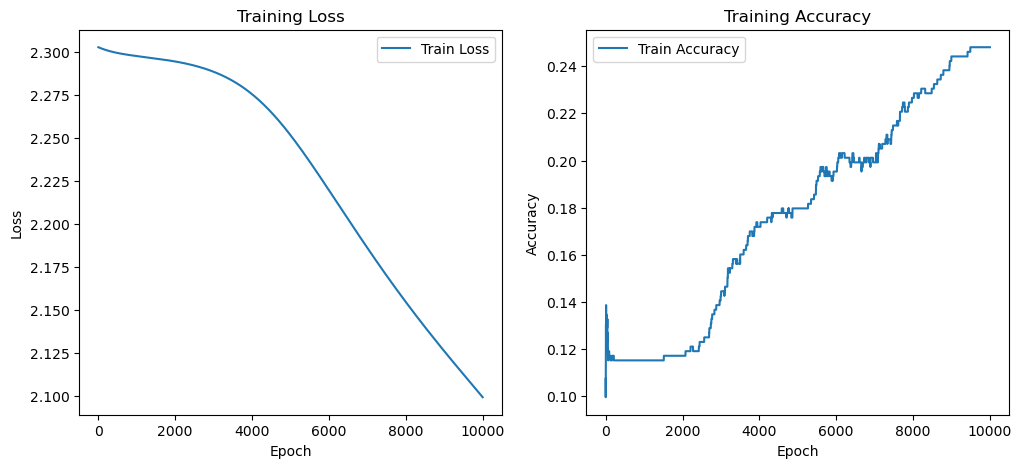

In [120]:
import numpy as np
import matplotlib.pyplot as plt

class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim, regularization_factor):
        # Initialize weights with small random values
        self.weights1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.biases1 = np.zeros(hidden_dim)
        self.weights2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.biases2 = np.zeros(output_dim)
        self.regularization_factor = regularization_factor

    def forward(self, X):
        X = np.asarray(X)
        # First layer
        self.z1 = np.dot(X, self.weights1) + self.biases1
        self.a1 = np.maximum(0, self.z1)  # ReLU activation
    
        # Second layer
        self.z2 = np.dot(self.a1, self.weights2) + self.biases2
        return self.softmax(self.z2)


    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def compute_loss(self, y, y_hat):
        # Cross-entropy loss with L2 regularization
        m = y.shape[0]
        log_likelihood = -np.log(y_hat[range(m), y] + 1e-9)
        loss = np.mean(log_likelihood) + (self.regularization_factor / 2) * (np.sum(np.square(self.weights1)) + np.sum(np.square(self.weights2)))
        return loss

    def backward(self, X, y):
        # Derivative of loss w.r.t. output
        m = y.shape[0]
        y_hat = self.forward(X)
        y_hat[range(m), y] -= 1
        y_hat /= m

        # Backpropagation to the second layer
        dW2 = np.dot(self.a1.T, y_hat) + self.regularization_factor * self.weights2
        dB2 = np.sum(y_hat, axis=0)
        dA1 = np.dot(y_hat, self.weights2.T)

        # Backpropagation through ReLU
        dZ1 = dA1 * (self.z1 > 0)

        # Backpropagation to the first layer
        dW1 = np.dot(X.T, dZ1) + self.regularization_factor * self.weights1
        dB1 = np.sum(dZ1, axis=0)

        return dW1, dB1, dW2, dB2

    def update_params(self, dW1, dB1, dW2, dB2, learning_rate):
        self.weights1 -= learning_rate * dW1
        self.biases1 -= learning_rate * dB1
        self.weights2 -= learning_rate * dW2
        self.biases2 -= learning_rate * dB2

    def predict(self, X):
        y_hat = self.forward(X)
        return np.argmax(y_hat, axis=1)

    def compute_accuracy(self, y, y_pred):
        return np.mean(y == y_pred)

input_dim=X_train.shape[1]
hidden_dim=100
output_dim=len(np.unique(y_train))
regularization_factor = 0.001
learning_rate = 0.01
epochs = 10000

# Initialize the MLP
mlp = MLP(input_dim, hidden_dim, output_dim, regularization_factor)

# Assume X_train, y_train are your training dataset
# Initialize loss and accuracy storage for plotting
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    y_hat_train = mlp.forward(X_train)
    train_loss = mlp.compute_loss(y_train, y_hat_train)
    train_losses.append(train_loss)

    dW1, dB1, dW2, dB2 = mlp.backward(X_train, y_train)
    mlp.update_params(dW1, dB1, dW2, dB2, learning_rate)

    y_pred_train = mlp.predict(X_train)
    train_accuracy = mlp.compute_accuracy(y_train, y_pred_train)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch + 1}: Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}")

# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [114]:

# Only split if you don't already have a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = MLP(input_dim=X_train.shape[1], hidden_dim=100, output_dim=len(np.unique(y_train)), regularization_factor=0.001)


In [115]:
epochs = 50
learning_rate = 0.01
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(epochs):
    # Training pass
    y_hat_train = model.forward(X_train)
    train_loss = model.compute_loss(y_train, y_hat_train)
    train_accuracy = model.compute_accuracy(y_train, model.predict(X_train))
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation pass
    y_hat_val = model.forward(X_val)
    val_loss = model.compute_loss(y_val, y_hat_val)
    val_accuracy = model.compute_accuracy(y_val, model.predict(X_val))
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Backward and update
    dW1, dB1, dW2, dB2 = model.backward(X_train, y_train)
    model.update_params(dW1, dB1, dW2, dB2, learning_rate)

    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")


Epoch 1: Train Loss = 2.3026, Train Accuracy = 0.1035, Val Loss = 2.3024, Val Accuracy = 0.1641
Epoch 2: Train Loss = 2.3026, Train Accuracy = 0.1035, Val Loss = 2.3024, Val Accuracy = 0.1562
Epoch 3: Train Loss = 2.3026, Train Accuracy = 0.1055, Val Loss = 2.3024, Val Accuracy = 0.1484
Epoch 4: Train Loss = 2.3026, Train Accuracy = 0.1113, Val Loss = 2.3024, Val Accuracy = 0.1406
Epoch 5: Train Loss = 2.3026, Train Accuracy = 0.1152, Val Loss = 2.3024, Val Accuracy = 0.1484
Epoch 6: Train Loss = 2.3026, Train Accuracy = 0.1152, Val Loss = 2.3024, Val Accuracy = 0.1484
Epoch 7: Train Loss = 2.3026, Train Accuracy = 0.1191, Val Loss = 2.3024, Val Accuracy = 0.1406
Epoch 8: Train Loss = 2.3026, Train Accuracy = 0.1172, Val Loss = 2.3024, Val Accuracy = 0.1406
Epoch 9: Train Loss = 2.3026, Train Accuracy = 0.1152, Val Loss = 2.3024, Val Accuracy = 0.1484
Epoch 10: Train Loss = 2.3025, Train Accuracy = 0.1172, Val Loss = 2.3024, Val Accuracy = 0.1484
Epoch 11: Train Loss = 2.3025, Train Ac

In [121]:
model = MLP(input_dim=X_test.shape[1], hidden_dim=100, output_dim=len(np.unique(y_test)), regularization_factor=0.001)

y_hat_test = model.forward(X_test)
test_loss = model.compute_loss(y_test, y_hat_test)
test_accuracy = model.compute_accuracy(y_test, model.predict(X_test))

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 2.4854, Test Accuracy: 0.0950


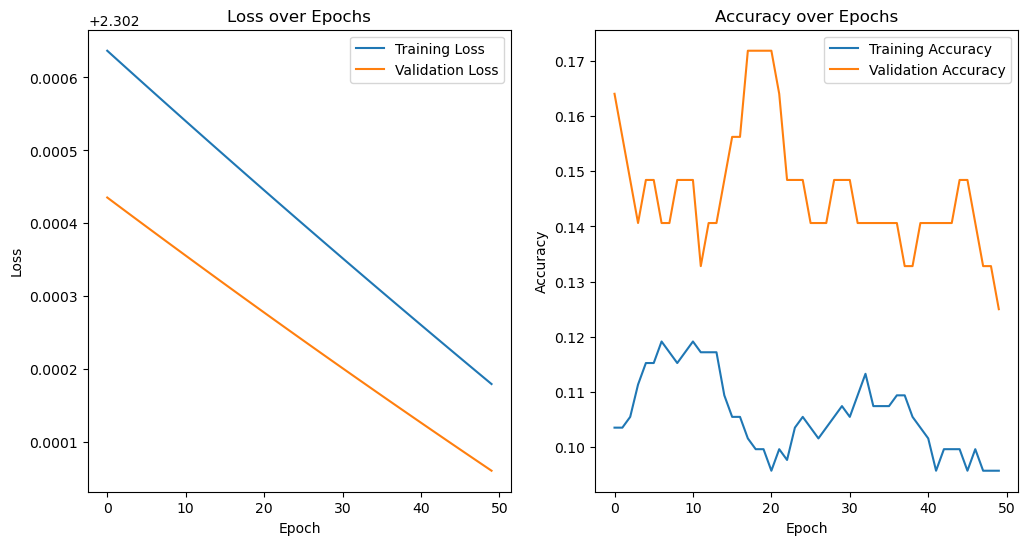

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import numpy as np

def mean_squared_error(y_true, y_pred):
    """
    Calculate the mean squared error (MSE) between true and predicted values.
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        Ground truth target values.
        
    y_pred : array-like of shape (n_samples,)
        Predicted target values.
        
    Returns:
    mse : float
        Mean squared error between true and predicted values.
    """
    return np.mean((y_true - y_pred) ** 2)

def accuracy(y_true, y_pred):
    """
    Calculate the accuracy between true and predicted values.
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        Ground truth target values.
        
    y_pred : array-like of shape (n_samples,)
        Predicted target values.
        
    Returns:
    acc : float
        Accuracy between true and predicted values, in the range [0, 1].
    """
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    return correct / total


# Decision Trees and Random Forests

## Introduction

Decision trees and random forests are powerful machine learning algorithms used for both classification and regression tasks. They are popular due to their simplicity, interpretability, and effectiveness in handling non-linear relationships and interactions between features.

## Decision Trees

A decision tree is a flowchart-like tree structure where each internal node represents a feature, each branch represents a decision based on that feature, and each leaf node represents a class label (in classification) or a continuous value (in regression). Decision trees are constructed recursively by splitting the dataset into subsets based on the value of a feature that maximizes the information gain or minimizes impurity.

### Entropy and Information Gain

Entropy is a measure of impurity in a dataset, calculated as:

$$
\text{Entropy}(S) = -\sum_{i=1}^{c} p_i \log_2(p_i)
$$

where $S$ is the dataset, $c$ is the number of classes, and $p_i$ is the proportion of samples belonging to class $i$ in $S$.

Information Gain measures the reduction in entropy achieved by splitting the dataset on a particular feature. It is calculated as:

$$
\text{IG}(S, A) = \text{Entropy}(S) - \sum_{v \in \text{Values}(A)} \frac{|S_v|}{|S|} \times \text{Entropy}(S_v)
$$

where $A$ is a feature, $\text{Values}(A)$ is the set of possible values of feature $A$, $S_v$ is the subset of $S$ where feature $A$ has value $v$.

## Random Forests

A random forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode (for classification) or mean (for regression) of the individual predictions of the trees. Random forests reduce overfitting by introducing randomness in the tree construction process, including:

1. **Random Sampling**: Each tree is trained on a bootstrap sample of the original dataset.
2. **Random Feature Selection**: At each node, a random subset of features is considered for splitting.

### Bagging and Bootstrap Sampling

Bootstrap sampling involves randomly sampling the dataset with replacement to create multiple subsets of the same size as the original dataset. Bagging (Bootstrap Aggregating) combines the predictions of multiple models trained on different bootstrap samples to reduce variance and improve performance.

### Out-of-Bag Error

Since each tree in a random forest is trained on a bootstrap sample, some samples are left out of each bootstrap sample. These out-of-bag (OOB) samples can be used to estimate the performance of the random forest without the need for cross-validation.


In [38]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None, root=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=root

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs


    def _entropy(self, y):
        y_int = np.ceil(y).astype(int)  # Convert float values to integers
        hist = np.bincount(y_int)
        ps = hist / len(y_int)
        return -np.sum([p * np.log(p) for p in ps if p > 0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [39]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        '''
        Constructor for the RandomForest class
        Arguments:
            n_trees: int, the number of trees in the random forest
            max_depth: int, the maximum depth of the tree
            min_samples_split: int, the minimum number of samples required to split an internal node
            n_feature: int, the number of features to consider when looking for the best split
        '''
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        ''' function to train the random forest
        Arguments:
            X: numpy array, the data for training
            y: numpy array, the target variable for training
        '''
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split
                            )
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        ''' function to create a sample dataset by bootstrapping
        Arguments:
            X: numpy array, the data for training
            y: numpy array, the target variable for training
        Returns:
            tuple: the sample dataset

        Bootstrapping creates a sample dataset from the original dataset by sampling with replacement.
        '''
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        ''' function to find the most common label in the target variable
        Arguments:
            y: numpy array, the target variable
        Returns:
            int: the most common label
        '''
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        ''' function to predict new dataset
        Arguments:
            X: numpy array, the data for prediction
        Returns:
            list: the predictions
        '''
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

In [40]:
from random import random
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

data = datasets.load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

# Lets change our hyperparameters a bit because Random Forest should ideally have a higher accuracy

In [41]:

clf = DecisionTree()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

acc =  accuracy(y_test, predictions)
print(f'Decision Tree Accuracy: {acc}')

clf = RandomForest(n_trees=30, n_feature = 5)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

acc =  accuracy(y_test, predictions)
print(f'Random Forest Accuracy: {acc}')

Decision Tree Accuracy: 0.9298245614035088
Random Forest Accuracy: 0.9385964912280702


# maybe try more trees, to increase random forest accuracy

In [47]:

clf = DecisionTree()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error of Decision Trees:", mse)
acc =  accuracy(y_test, predictions)
print(f'Decision Tree Accuracy: {acc}')

clf = RandomForest(n_trees=30, n_feature = 3)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
acc =  accuracy(y_test, predictions)
print(f'Random Forest Accuracy: {acc}')

Mean Squared Error of Decision Trees: 0.04678362573099415
Decision Tree Accuracy: 0.9532163742690059
Random Forest Accuracy: 0.9590643274853801


# Gradient Boosted Trees

## Gradient Boosting

Gradient boosting is a machine learning technique for regression and classification problems that produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion, where each new tree helps to correct errors made by previously trained trees. The key idea behind gradient boosting is to fit a new model to the residual errors made by the previous models.

### Gradient Descent

Gradient boosting involves optimizing a loss function by using gradient descent. In each stage of training, a new weak learner (usually a decision tree) is added to the ensemble to minimize the loss function. The predictions of all the weak learners are combined to produce the final prediction.

### Shrinkage (Learning Rate)

Shrinkage, also known as the learning rate, is a hyperparameter in gradient boosting that controls the contribution of each tree to the ensemble. A smaller learning rate requires more trees to be added to the ensemble but can lead to better generalization.

## AdaBoost

AdaBoost (Adaptive Boosting) is a specific implementation of the gradient boosting algorithm that focuses on classification problems. In AdaBoost, each weak learner is trained sequentially on the dataset, with more weight given to instances that were misclassified by previous learners. The final prediction is a weighted sum of the predictions of all weak learners.

### Weighted Error

In AdaBoost, each weak learner is assigned a weight based on its performance on the training data. The weight is higher for learners that perform well and lower for those that perform poorly. This allows AdaBoost to focus more on difficult-to-classify instances and improve overall accuracy.

## XGBoost and LightGBM

XGBoost (Extreme Gradient Boosting) and LightGBM are popular implementations of gradient boosting that are optimized for performance and scalability. They offer several enhancements over traditional gradient boosting, including parallelization, tree pruning, and regularization.

### Regularization

Regularization techniques, such as L1 and L2 regularization, are used in XGBoost and LightGBM to prevent overfitting and improve generalization. These techniques penalize complex models by adding a regularization term to the loss function.



In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class GradientBoostedTrees:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.estimators = []

    def fit(self, X, y):
        # Initialize predictions with the mean of y
        y_pred = np.full(y.shape, np.mean(y), dtype=np.float64)
        
        for _ in range(self.n_estimators):
            # Compute residuals
            residuals = y - y_pred
            
            # Fit a decision tree to the residuals
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X, residuals)
            
            # Update predictions
            update = tree.predict(X)
            y_pred += self.learning_rate * update
            
            # Add the tree to the list of estimators
            self.estimators.append(tree)

    def predict(self, X):
        y_pred = np.full(X.shape[0], np.mean(y), dtype=np.float64)
        for tree in self.estimators:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

# Generate synthetic data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate and fit model
model = GradientBoostedTrees(n_estimators=10, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

# Predict and calculate accuracy
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error of Gradient Boosted Trees:", mse)

Mean Squared Error of Gradient Boosted Trees: 0.3207451087829183


### Gradient Boosted Trees in this case have a lower MSE than Decision Trees and hence are much better than Decision Trees alone

In [ ]:
# Importing the required libraries and examples
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
import cv2

# We will make classes for all the layers
# Convolutional Layer
class Convolution:
    def _init_(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.conv_filter = np.random.randn(num_filters, filter_size, filter_size) / filter_size**2
        self.stride = 1
        self.padding = 0

    def image_region(self, image):
        height, width = image.shape
        self.image = image
        for j in range(height - self.filter_size + 1):
            for k in range(width - self.filter_size + 1):
                image_patch = image[j:(j + self.filter_size), k:(k + self.filter_size)]
                yield image_patch, j, k

    def forward_prop(self, image):
        height, width = image.shape
        conv_out = np.zeros((height - self.filter_size + 1, width - self.filter_size + 1, self.num_filters))
        for image_patch, i, j in self.image_region(image):
            conv_out[i, j] = np.sum(image_patch * self.conv_filter, axis=(1, 2))
        return conv_out

    def back_prop(self, dL_dout, learning_rate):
        dL_dF_params = np.zeros(self.conv_filter.shape)
        for image_patch, i, j in self.image_region(self.image):
            for k in range(self.num_filters):
                dL_dF_params[k] += image_patch * dL_dout[i, j, k] # dL-dout would come from Maxpool layer
        self.conv_filter -= learning_rate * dL_dF_params
        return dL_dF_params

# let us test the Convolution class
conv = Convolution()
out = conv.forward_prop(img)
out.shape

plt.imshow(out[:, :, 17], cmap='gray')
plt.show()

# Maxpool Layer
class Maxpool:
    def _init_(self, filter_size):
        self.filter_size = filter_size
        self.stride = 2

    def image_region(self, image):
        new_height = image.shape[0] // self.stride
        new_width = image.shape[1] // self.stride
        self.image = image
        for i in range(new_height):
            for j in range(new_width):
                image_patch = image[(i * self.stride):(i * self.stride + self.filter_size), (j * self.stride):(j * self.stride + self.filter_size)]
                yield image_patch, i, j

    def forward_prop(self, image):
        height, width, num_filters = image.shape
        self.num_filters = num_filters
        pool_out = np.zeros((height // self.stride, width // self.stride, num_filters))
        for image_patch, i, j in self.image_region(image):
            pool_out[i, j] = np.amax(image_patch, axis=(0, 1))
        return pool_out

    def back_prop(self, dL_dout):
        dL_dpool = np.zeros(self.image.shape)
        for image_patch, i, j in self.image_region(self.image):
            height, width, num_filters = image_patch.shape
            maximum_val = np.amax(image_patch, axis=(0, 1))
            for i1 in range(height):
                for j1 in range(width):
                    for k1 in range(num_filters):
                        if image_patch[i1, j1, k1] == maximum_val[k1]:
                            dL_dpool[i * 2 + i1, j * 2 + j1, k1] = dL_dout[i, j, k1]
        return dL_dpool

# Let us test the Maxpool class
pool1 = Maxpool(4)
out2 = pool1.forward_prop(out)
out2.shape

plt.imshow(out[:, :, 17], cmap='gray')
plt.show()

# Softmax Layer
class Softmax:
    def _init_(self, input_node, softmax_node):
        self.weight = np.random.randn(input_node, softmax_node) / input_node
        self.bias = np.zeros(softmax_node)

    def forward_prop(self, image):
        self.orig_im_shape = image.shape
        image_modified = image.flatten()
        self.modified_input = image_modified
        output_val = np.dot(image_modified, self.weight) + self.bias
        self.out = output_val
        exp_out = np.exp(output_val)
        return exp_out / np.sum(exp_out, axis=0)

    def back_prop(self, dL_dout, learning_rate):
        for i, grad in enumerate(dL_dout):
            if grad == 0:
                continue
            transformation_eq = np.exp(self.out)
            S_total = np.sum(transformation_eq)

            # Gradients with respect to out (z)
            dy_dz = -transformation_eq[i] * transformation_eq / S_total**2
            dy_dz[i] = transformation_eq[i] * (S_total - transformation_eq[i]) / S_total**2

            # Gradients of totals against weights/biases/input
            dz_dw = self.modified_input
            dz_db = 1
            dz_d_inp = self.weight

            # Gradients of loss against totals
            dL_dz = grad * dy_dz

            # Gradients of loss against weights/biases/input
            dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
            dL_db = dL_dz * dz_db
            dL_d_inp = dz_d_inp @ dL_dz

            # Update weights / biases
            self.weight -= learning_rate * dL_dw
            self.bias -= learning_rate * dL_db

            return dL_d_inp.reshape(self.orig_im_shape)

# Let us test the Softmax class
softmax = Softmax(13*13*18, 10)
out3 = softmax.forward_prop(out)
out3.shape

# Load the MNIST dataset
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255

# We can turn these functions into a class
class CNN:
    def _init_(self):
        self.conv = Convolution(8, 3)
        self.pool = Maxpool(2)
        self.softmax = Softmax(13*13*8, 10)

    def forward_prop(self, image, label):
        out_p = self.conv.forward_prop(image)
        out_p = self.pool.forward_prop(out_p)
        out_p = self.softmax.forward_prop(out_p)

        cross_entropy = -np.log(out_p[label])
        accuracy_eval = 1 if np.argmax(out_p) == label else 0

        return out_p, cross_entropy, accuracy_eval

    def train(self, image, label, learning_rate=0.005):
        out, loss, acc = self.forward_prop(image, label)

        gradient = np.zeros(10)
        gradient[label] = -1 / out[label]

        gradient = self.softmax.back_prop(gradient, learning_rate)
        gradient = self.pool.back_prop(gradient)
        gradient = self.conv.back_prop(gradient, learning_rate)

        return loss, acc

cnn = CNN()
# Training the model
for epoch in range(3):
    print('Epoch %d ----->' % (epoch + 1))
    permutation = np.random.permutation(len(X_train))
    X_train = X_train[permutation]
    y_train = y_train[permutation]
    loss = 0
    num_correct = 0
    for i, (image, label) in enumerate(zip(X_train, y_train)):
        if i % 100 == 0:
            print('%d steps out of 60000 steps: Average Loss %.3f and Accuracy: %d%%' % (i, loss / i, num_correct / i * 100))
        l, acc = train(image, label)
        loss += l
        num_correct += acc

# Testing the model
print('Testing the model ----->')
loss = 0
num_correct = 0
for image, label in zip(X_test, y_test):
    _, l, acc = cnn_forward(image, label)
    loss += l
    num_correct += acc

num_tests = len(X_test)
print('Test Loss: ', loss / num_tests)
print('Test Accuracy: ', num_correct / num_tests)

In [80]:
import numpy as np

class AdaBoostM2:
    def _init_(self, classifiers, num_classes):
        self.classifiers = classifiers
        self.num_classes = num_classes
        self.alphas = []
        
    def fit(self, X, y, T):
        n_samples = X.shape[0]
        D = np.ones((n_samples, self.num_classes)) / (n_samples * self.num_classes)
        
        for t in range(T):
            for classifier in self.classifiers:
                weights = D.sum(axis=1)
                classifier.fit(X, y, sample_weight=weights)
                predictions = classifier.predict(X)
                indicator = (predictions != y[:, None]).astype(int)
                error = np.sum(weights * indicator) / np.sum(weights)
                
                if error >= 1 - 1 / self.num_classes:
                    continue  # Poor classifier, skip it
                
                alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
                self.alphas.append((classifier, alpha))
                
                # Update D
                for i in range(n_samples):
                    D[i, predictions[i]] *= np.exp(alpha)
                D /= D.sum()

    def predict(self, X):
        final_votes = np.zeros((X.shape[0], self.num_classes))
        for classifier, alpha in self.alphas:
            predictions = classifier.predict(X)
            for i in range(X.shape[0]):
                final_votes[i, predictions[i]] += alpha
                
        return np.argmax(final_votes, axis=1)

In [ ]:
# Assuming X_train, y_train are your training data and labels.
# You would need to define CNN, MLP, DecisionTree classes.

cnn = CNN(input_dim, num_filters, ...)
mlp = MLP(input_size, hidden_size, output_size)
dt = DecisionTree(max_depth, min_samples_split)

ensemble = AdaBoostM2([cnn, mlp, dt], num_classes)
ensemble.fit(X_train, y_train, T=10)

# Evaluate ensemble
predictions = ensemble.predict(X_test)
print("Ensemble Accuracy:", accuracy_score(y_test, predictions))

# Train standalone models and compare
cnn.fit(X_train, y_train)
mlp.fit(X_train, y_train)
dt.fit(X_train, y_train)

# Assuming a function accuracy_score to calculate accuracy
print("CNN Accuracy:", accuracy_score(y_test, cnn.predict(X_test)))
print("MLP Accuracy:", accuracy_score(y_test, mlp.predict(X_test)))
print("DT Accuracy:", accuracy_score(y_test, dt.predict(X_test)))